Task:
- Build a model that predicts "charges" for a given person based on their features.
- Evaluate the quality of your model.
- Identify the factors with the highest impact.


Body Mass Index (BMI):<br>
    I = $\frac{m}{h^2}$  <br>
    
    where 
   - m - weight in kg, 
   - h - height in m

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
df_insurance = pd.read_csv("./insurance.csv")

In [55]:
df_insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [56]:
df_insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


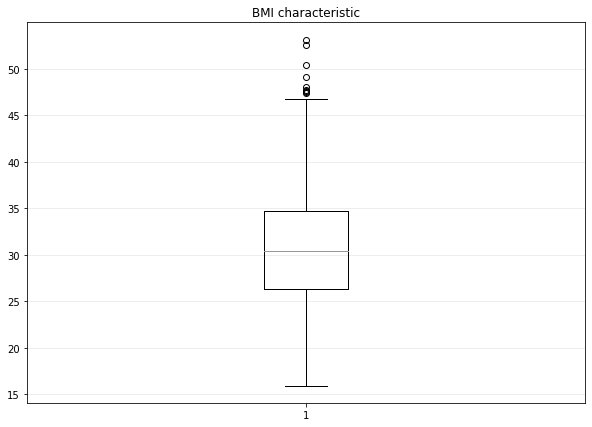

In [101]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.set_title("BMI characteristic")
ax.yaxis.grid(True, linestyle='-', color='lightgrey', alpha=0.5)
ax.boxplot(df_insurance.bmi)

plt.show()

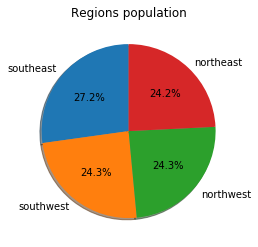

In [93]:
fig, ax = plt.subplots()

regions_names = df_insurance.region.value_counts().index
region_population = df_insurance.region.value_counts().values

ax.set_title("Regions population")
ax.pie(region_population, labels=regions_names, 
         autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

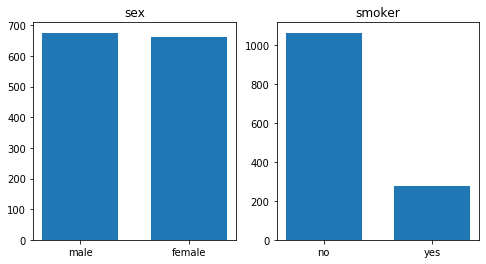

In [59]:
fig, (ax_sex, ax_smoker) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax_sex.set_title("sex")
ax_smoker.set_title("smoker")

sex_names = df_insurance.sex.value_counts().index
sex_cnt = df_insurance.sex.value_counts().values

smoke_answers = df_insurance.smoker.value_counts().index
smokers_cnt = df_insurance.smoker.value_counts().values

ax_sex.bar(sex_names, sex_cnt, width=0.7)
ax_smoker.bar(smoke_answers, smokers_cnt, width=0.7)
plt.show()

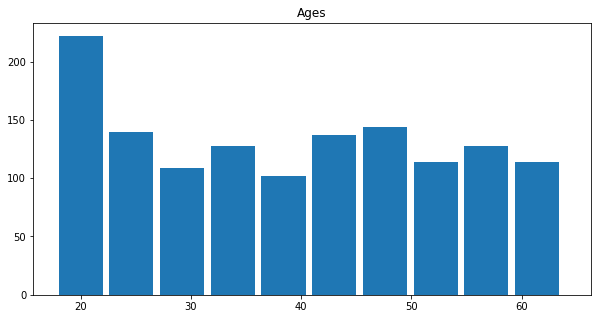

In [91]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(df_insurance.age, width=4)
ax.set_title("Ages")
plt.show()

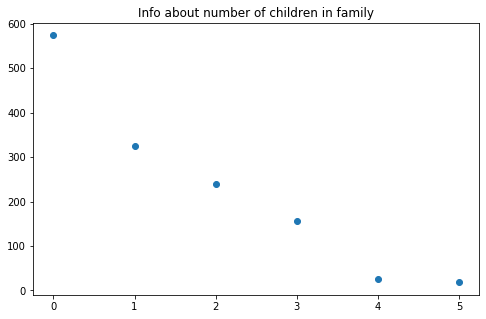

In [90]:
fig, ax = plt.subplots(figsize=(8, 5))

has_children = df_insurance.children.value_counts().index
children_cnt = df_insurance.children.value_counts().values
ax.set_title("Info about number of children in family")
ax.plot(has_children, children_cnt, 'o')
plt.show()

In [7]:
# 0 - male
# 1 - female
df_insurance.loc[df_insurance.sex == "male", "sex"] = 0
df_insurance.loc[df_insurance.sex == "female", "sex"] = 1

In [8]:
# 0 - no
# 1 - yes
df_insurance.loc[df_insurance.smoker == "yes", "smoker"] = 1
df_insurance.loc[df_insurance.smoker == "no", "smoker"] = 0

In [9]:
df_insurance

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,southwest,16884.92400
1,18,0,33.770,1,0,southeast,1725.55230
2,28,0,33.000,3,0,southeast,4449.46200
3,33,0,22.705,0,0,northwest,21984.47061
4,32,0,28.880,0,0,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,0,30.970,3,0,northwest,10600.54830
1334,18,1,31.920,0,0,northeast,2205.98080
1335,18,1,36.850,0,0,southeast,1629.83350
1336,21,1,25.800,0,0,southwest,2007.94500


Plan:
    + change sex (on numbers)
    + change smoker
    + draw +age, +sex, +children, +smoker
    
    - change region
    - scale age, sex(no), bmi, children, smoker(no), region(?)    
    - mix data
    - split on train - test
    - create pipline
    - baseline (Linear Regression)
    - tune baseline (CV, find hyperparameters)
    - check on overfitting/underfitting (regularisation)
    - try to find more complex and good model (XGBoost, CatBoost)
    - accuracy (and look on metrics (J))
    - find and show more important features (more important factors)